# Análisis de la data de clutter

En este cuaderno veremos las estadisticas más básicas de nuestros datos. A diferencia del código anterior, esta vez usaré las funciones ya vistas directamente del módulo propio. 

In [2]:
from pathlib import Path
import wradlib as wrl
import matplotlib.pyplot as plt
import numpy as np
import warnings 

import Bases_GUI as radar
import utilidades as util

from scipy.stats import mode

warnings.filterwarnings('ignore')

Realizamos los pasos del código anterior para cargar los archivos. 

In [3]:
ruta = 'C:\Python37\Clutter'
clutterdata = util.dataclass(ruta)

Los objetos de la clase RadarData constan de la data(data, azi y range) así como de la metadata más importante. Por comodidad procesaremos los datos de reflectividad usando una matriz. 

In [4]:
def matriz3d(clutterdata):
    """Función que proporciona una matriz de tres ejes en base a una lista de objetos Radardata
    Argumentos:
        clutterdata (list) Lista con los objetos Radardata
    Salidas:
        matriz (np.array) Matriz de tamaño (360,1000,len(clutterdata)) que contiene todos los datos de reflectividad 
                          de los objetos. """
    matriz = np.zeros((360, 1000, len(clutterdata)))
    for index, clutter in enumerate(clutterdata):
        data_dbz = clutter.data['data']
        matriz[:, :, index] = data_dbz
    return matriz

In [5]:
Matriz = matriz3d(clutterdata)

Veamos sus dimensiones:

In [6]:
print(Matriz.shape)

(360, 1000, 63)


El clutter tiene poca variabilidad temporal, por lo que podemos realizar diversos procedimientos para combinar los datos del eje temporal. Los más sencillos corresponden a la estadística descriptiva(min, max, etc).

In [7]:
Clutter_min = np.min(Matriz, axis=2)
Clutter_max = np.max(Matriz, axis=2)
Clutter_mean = np.mean(Matriz, axis=2)
Clutter_median = np.median(Matriz, axis=2)

Para tener un enfoque de la distribución también incluiremos los otros cuartiles y la moda.

In [8]:
Clutter_low_cuartil = np.percentile(Matriz, q=25, axis=2)
Clutter_upper_cuartil = np.percentile(Matriz, q=75, axis=2)

Clutter_mode = mode(Matriz, axis=2)[0]
Clutter_mode = Clutter_mode[:, :, 0]

Colocamos los datos en una lista para procesarlos de manera más sencilla. 

In [9]:
resultados = [Clutter_min, Clutter_low_cuartil, Clutter_mean, Clutter_median,
                  Clutter_upper_cuartil, Clutter_max]
title = ['Mínimo', 'Primer cuartil', 'Media', 'Mediana', 'Tercer Cuartil', 'Máximo']
azi,r = util.ejes()

Realizamos un consolidado de los resultados:

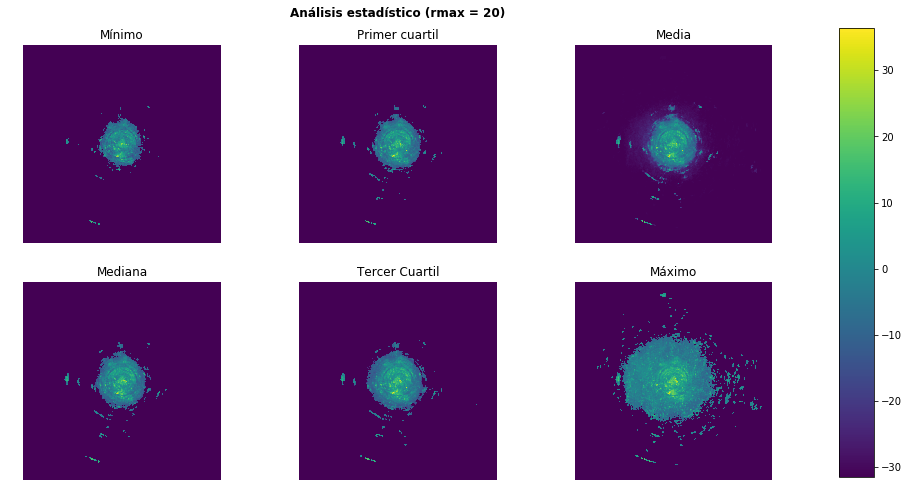

In [10]:
fig = plt.figure(figsize=(14, 8))    
tmp = plt.title('Análisis estadístico (rmax = 20)', fontweight='bold')
tmp.set_y(1.05)
plt.axis('off')
for i in range(231, 237):
    ax = fig.add_subplot(i)
    ax, pm = wrl.vis.plot_ppi(resultados[i - 231], r=r, az=azi, ax=ax)    
    ax = util.complement_ax(ax)
    ax.set_title(title[i-231])
    ax.axis('off')
cax = plt.axes([0.95, 0.13, 0.035, 0.78])
fig.colorbar(pm, cax=cax)

La moda en cambio:

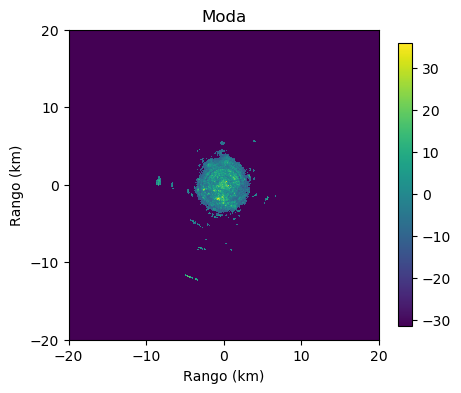

In [11]:
fig = util.ploteo(Clutter_mode, title='Moda', rmax=20, colorbar=True)

Como se puede apreciar, el clutter tiene dos componentes, una bastante fija cerca del radar mientras que una segunda parte(constituida presumiblemente por ruido) se presenta un poco más lejos. Esta segunda componente se nota principalmente en la gráfica de Máximos, por lo que el ruido tiende a tener valores mucho más altos que el fondo(valores de reflectividad mínimos -31.5 dBZ) pero que se presentan con una frecuencia relativamente baja. Esto debería llevarte a deducir que la zona ruidosa no se puede modelar como una sola distribución sino más bien como la suma de al menos dos distribuciones.

Para enfocarnos en cuan presente esta el ruido calcularemos cuántas veces en la matriz un valor ha sido diferente del valor de reflectividad mínima(-31.5 dBZ).

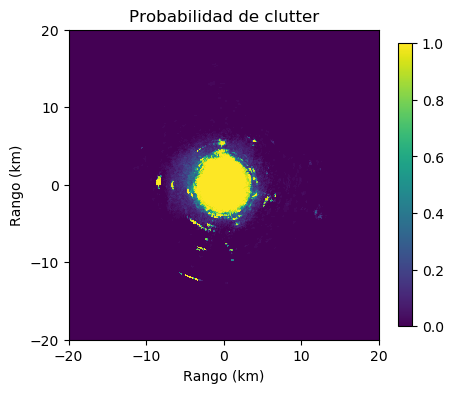

In [12]:
    Clutter_density = np.sum(Matriz > -31.5, axis=2)/len(clutterdata)
    fig = util.ploteo(Clutter_density, title='Probabilidad de clutter', rmax=20, colorbar=True)

Se aprecia que la zona de ruido presenta una probabilidad aproximada de 0.4. Debido a los obstáculos artificiales y a la refracción de los lóbulos laterales del radar, los primeros 6 km parecen ser no aprovechables. Dado que estos datos proceden de
"precipitation free conditions" el resultado final debería ser una matriz que tenga todos sus valores de reflectividad al mínimo. 

Otro gráfico que resulta práctico es la distribución de los píxeles(histograma).

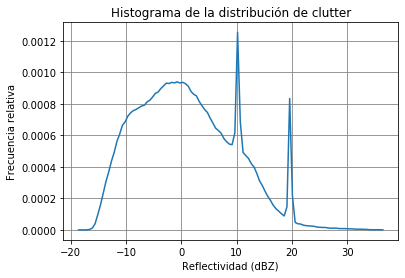

In [13]:
unique, counts = np.unique(Matriz, return_counts=True)
counts = counts / (360 * 1000 * len(clutterdata))
plt.plot(unique[1:], counts[1:], label='Consolidado')
plt.title('Histograma de la distribución de clutter')
plt.xlabel('Reflectividad (dBZ)')
plt.ylabel('Frecuencia relativa')
plt.grid(color='gray')

En el gráfico anterior no se ha mostrado la frecuencia relativa correspondiente a los valores de -31.5 pues dicho valor ocupa la mayor frecuencia relativa en el histograma y de colocarlo no se notaría la distribución del clutter. Aquí se observa que el valor mínimo de clutter es un poco mayor a -20 dBZ, mientras que el mayor corresponde a cerca de 38 dBZ. La distribución presenta una gran concentración de valores en torno a 10 y 20 dBZ.

Hasta ahora las estadísticas presentadas han ignorado la distribución espacial de los datos. Antes de entrar a ello veremos a detalle el clutter central.

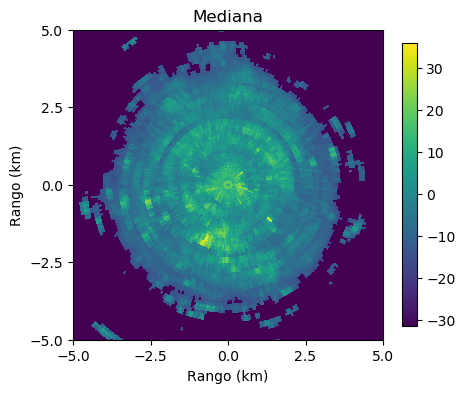

In [14]:
fig = util.ploteo(Clutter_median, title='Mediana', rmax=5, colorbar=True)

Los datos graficados siguen estando en la grilla polar y no en la representación cartesiana a la cual solemos estar acostumbrados. Esto tiene algunas consecuencias importantes:

1) La resolución de los datos es variable respecto al eje radial.

2) Los datos no se encuentran en el eje cartesiano. Convertirlos implicará aplicar algoritmos de interpolación que debemos analizar.

3) En la medida de lo posible los procesos deberán llevarse a cabo sobre estos datos y no sobre los proyectados pues se perderá la calidad original. 

Retomando el ánalisis espacial, los recursos más utilizados para la caracterización del clutter corresponden al ánalisis de texturas. Se evalúa la homogeneidad de los datos cercanos usando una ventana cuadrada, en nuestro caso usaremos ventanas de 3x3 y 5x5.   

In [15]:
def texture(matriz,half_wsize):
    wsize = 2*half_wsize + 1
    element = matriz.copy()
    shift = range(-half_wsize,half_wsize + 1)
    count = np.zeros_like(element)
    for i in shift:
        tmpa = np.roll(element, i, axis=0)
        for j in shift:
            tmpr = np.roll(tmpa, j, axis=1)
            count += abs(tmpr - element)
    count = count / wsize **2
    return count

In [16]:
# Seleccionamos una al azar para evaluar
data = Matriz[:,:,5]
texture3 = texture(data, 1)
texture5 = texture(data, 2)

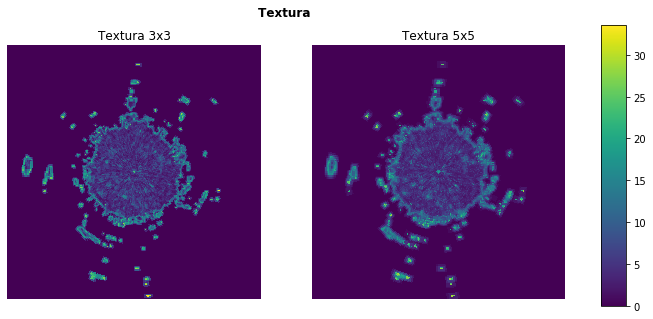

In [17]:
fig = plt.figure(figsize=(10, 5))    
tmp = plt.title('Textura ', fontweight='bold')
tmp.set_y(1.05)
plt.axis('off')

ax = fig.add_subplot(121)
ax, pm = wrl.vis.plot_ppi(texture3, r=r, az=azi, ax=ax)    
ax = util.complement_ax(ax, rmax=10)
ax.set_title('Textura 3x3')
ax.axis('off')

ax = fig.add_subplot(122)
ax, pm = wrl.vis.plot_ppi(texture5, r=r, az=azi, ax=ax)    
ax = util.complement_ax(ax, rmax=10)
ax.set_title('Textura 5x5')
ax.axis('off')

cax = plt.axes([0.95, 0.13, 0.035, 0.78])
fig.colorbar(pm, cax=cax)

Calcularemos lo mismo en el máximo para ver la distribución en el ruido. 

In [18]:
texture3max = texture(Clutter_max,1)
texture5max = texture(Clutter_max,2)

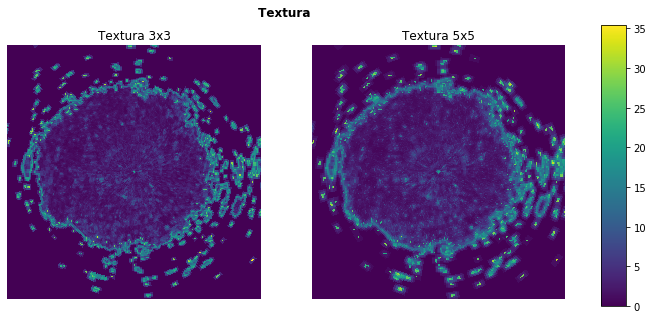

In [19]:
fig = plt.figure(figsize=(10, 5))    
tmp = plt.title('Textura ', fontweight='bold')
tmp.set_y(1.05)
plt.axis('off')

ax = fig.add_subplot(121)
ax, pm = wrl.vis.plot_ppi(texture3max, r=r, az=azi, ax=ax)    
ax = util.complement_ax(ax, rmax=10)
ax.set_title('Textura 3x3')
ax.axis('off')

ax = fig.add_subplot(122)
ax, pm = wrl.vis.plot_ppi(texture5max, r=r, az=azi, ax=ax)    
ax = util.complement_ax(ax, rmax=10)
ax.set_title('Textura 5x5')
ax.axis('off')

cax = plt.axes([0.95, 0.13, 0.035, 0.78])
fig.colorbar(pm, cax=cax)

Gabella muestra una implementación discreta basada en un umbral de 6 dBZ como parte "a" de su filtro. En la función los valores máximos representan zonas muy homogéneas. 

In [20]:
def pseudo_gabella(matriz,half_wsize,thr):
    element = matriz.copy()
    shift = range(-half_wsize,half_wsize + 1)
    count = - np.ones_like(element)
    for i in shift:
        tmpa = np.roll(element, i, axis=0)
        for j in shift:
            tmpr = np.roll(tmpa, j, axis=1)
            count += (tmpr - element) > thr
    return count

In [21]:
texture3 = pseudo_gabella(data, half_wsize=1, thr=6)
texture5 = pseudo_gabella(data, half_wsize=2, thr=6)


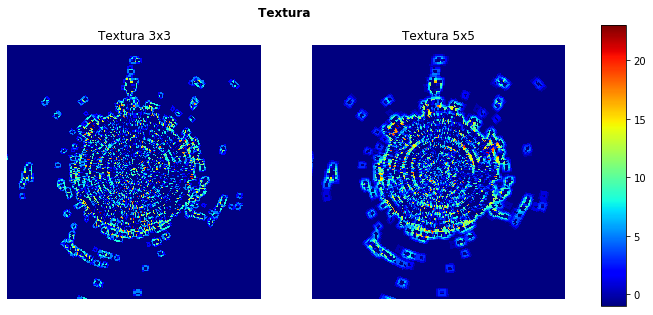

In [22]:
fig = plt.figure(figsize=(10, 5))    
tmp = plt.title('Textura ', fontweight='bold')
tmp.set_y(1.05)
plt.axis('off')

ax = fig.add_subplot(121)
ax, pm = wrl.vis.plot_ppi(texture3,r=r, az=azi, ax=ax, cmap=plt.cm.jet)    
ax = util.complement_ax(ax, rmax=8)
ax.set_title('Textura 3x3')
ax.axis('off')

ax = fig.add_subplot(122)
ax, pm = wrl.vis.plot_ppi(texture5, r=r, az=azi, ax=ax,cmap=plt.cm.jet)    
ax = util.complement_ax(ax, rmax=8)
ax.set_title('Textura 5x5')
ax.axis('off')

cax = plt.axes([0.95, 0.13, 0.035, 0.78])
fig.colorbar(pm, cax=cax)

En ambos enfoques se puede ver que la textura es un excelente discriminador para elementos sueltos (enfoque usado por Gabella), mientras que no es realmente caracteristico de la zona más cercana del radar. Ello hace sospechar que las causas del clutter cercano al radar sean objetos pequeños (artificiales probablemente) pero de altísima reflectividad. Dado que en las proximidades del radar es más probable que los ecos se propagen a los datos adyacentes en el eje azimuth(pues la distancia es menor), en consecuencia, evaluaremos la textura azimuth. 

In [23]:
def texture_eje(matriz,half_wsize, axis=0):
    wsize = 2*half_wsize + 1
    element = matriz.copy()
    shift = range(-half_wsize,half_wsize + 1)
    count = np.zeros_like(element)
    for i in shift:
        tmpa = np.roll(element, i, axis=axis)
        count += abs(tmpa - element)
    count = count / wsize
    return count

In [24]:
texture3 = texture_eje(data, half_wsize=1)
texture5 = texture_eje(data, half_wsize=2)

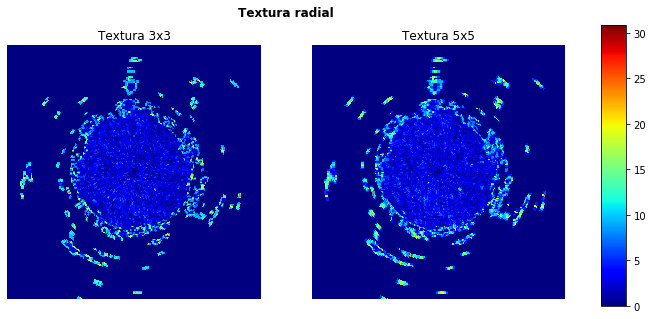

In [25]:
fig = plt.figure(figsize=(10, 5))    
tmp = plt.title('Textura radial', fontweight='bold')
tmp.set_y(1.05)
plt.axis('off')

ax = fig.add_subplot(121)
ax, pm = wrl.vis.plot_ppi(texture3,r=r, az=azi, ax=ax, cmap=plt.cm.jet)    
ax = util.complement_ax(ax, rmax=8)
ax.set_title('Textura 3x3')
ax.axis('off')

ax = fig.add_subplot(122)
ax, pm = wrl.vis.plot_ppi(texture5, r=r, az=azi, ax=ax,cmap=plt.cm.jet)    
ax = util.complement_ax(ax, rmax=8)
ax.set_title('Textura 5x5')
ax.axis('off')

cax = plt.axes([0.95, 0.13, 0.035, 0.78])
fig.colorbar(pm, cax=cax)

Se puede apreciar que ahora si hemos conseguido una textura prácticamente uniforme, por lo que la suposición que había realizado es probablemente correcta. Observe que los cambios bruscos de textura no tienen ninguna dirección preferente.

Pero tambien bajo el enfoque de Gabella, donde se verá si esto es cierto o no de forma más palpable.

In [26]:
def pseudogabella_eje(matriz, half_wsize, axis=0, thr=6):
    wsize = 2*half_wsize + 1
    element = matriz.copy()
    shift = range(-half_wsize,half_wsize + 1)
    count = -np.ones_like(element)
    for i in shift:
        tmpa = np.roll(element, i, axis=axis)
        count += (tmpa - element) < thr
    count = count/ wsize
    return count

In [27]:
texture3 = pseudogabella_eje(data, half_wsize=1)
texture5 = pseudogabella_eje(data, half_wsize=2)

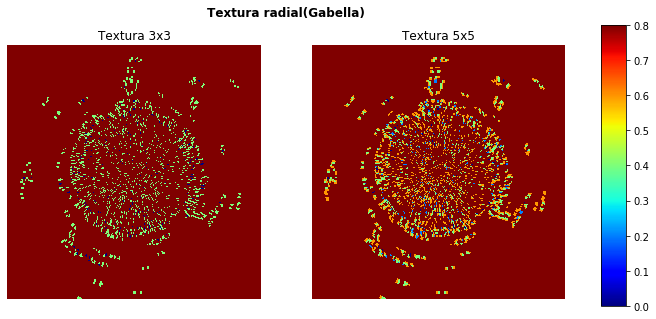

In [28]:
fig = plt.figure(figsize=(10, 5))    
tmp = plt.title('Textura radial(Gabella)', fontweight='bold')
tmp.set_y(1.05)
plt.axis('off')

ax = fig.add_subplot(121)
ax, pm = wrl.vis.plot_ppi(texture3,r=r, az=azi, ax=ax, cmap=plt.cm.jet)    
ax = util.complement_ax(ax, rmax=8)
ax.set_title('Textura 3x3')
ax.axis('off')

ax = fig.add_subplot(122)
ax, pm = wrl.vis.plot_ppi(texture5, r=r, az=azi, ax=ax,cmap=plt.cm.jet)    
ax = util.complement_ax(ax, rmax=8)
ax.set_title('Textura 5x5')
ax.axis('off')

cax = plt.axes([0.95, 0.13, 0.035, 0.78])
fig.colorbar(pm, cax=cax)

Parece ser que el resultado aquí no es tal y como esperabamos, pero aún así veremos si este efecto es característico solo del clutter o no.

Para terminar con la caracterización de los datos, nos falta encontrar algunas de sus características puntuales. 

In [29]:
mask_matriz = np.ma.masked_values(Matriz, -31.5)

In [30]:
print('Máximo: ', np.max(mask_matriz))
print('Mínimo:', np.min(mask_matriz))

Máximo:  36.46484375
Mínimo: -18.6015625


Por último calcularemos la extensión superficial promedio del clutter en conjunto. 

In [31]:
Area = util.area_matriz()
binimg = Clutter_median > -31.5
mask_median = np.ma.masked_array(Area, mask=~binimg)
print('Área: ',np.sum(mask_median), 'm2')

Área:  56811688.88289182 m2


A partir de los datos hemos identificado algunas de las características del clutter que nos servirán para realizar discriminaciones de los datos y realizar filtrados. Sin embargo, este analísis no estaría completo si no presentamos algunos
datos de precipitación para compararlos con los ya presentados. 

En el próximo cuaderno, analizaremos algunos datos de precipitación para observar si tienen o no las mismas propiedades. 